## Running `tractor` on the ladybug sample
### (Forced photometry not included.)

In [2]:
# import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

import scarlet # for generating RGB images (solely for display purposes)

from unagi import hsc, config
from unagi import plotting
from unagi import task, catalog


In [3]:
from tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_iteration

In [4]:
# load catalog and images
obj_cat = Table.read('/home/diana/Research/ladybug_tractor/ladybug/ladybug-2021-03-03.fits')

In [5]:
#obj_cat['name']

In [6]:
from kuaizi.tractor.utils import tractor_hsc_sep

channels = 'grizy'

# save all the files to './output'
import os
#os.chdir('./output')
os.getcwd()

'/home/diana/Research/ladybug_tractor'

### `ladybug_180` g-band
    Detected 3 objects
!!!The file "./tractor-1498p025.fits" already exists!!!
# Type of the central object is REX
# Total number of objects: 3
 - Now you have 1 sources
 - Now you have 2 sources


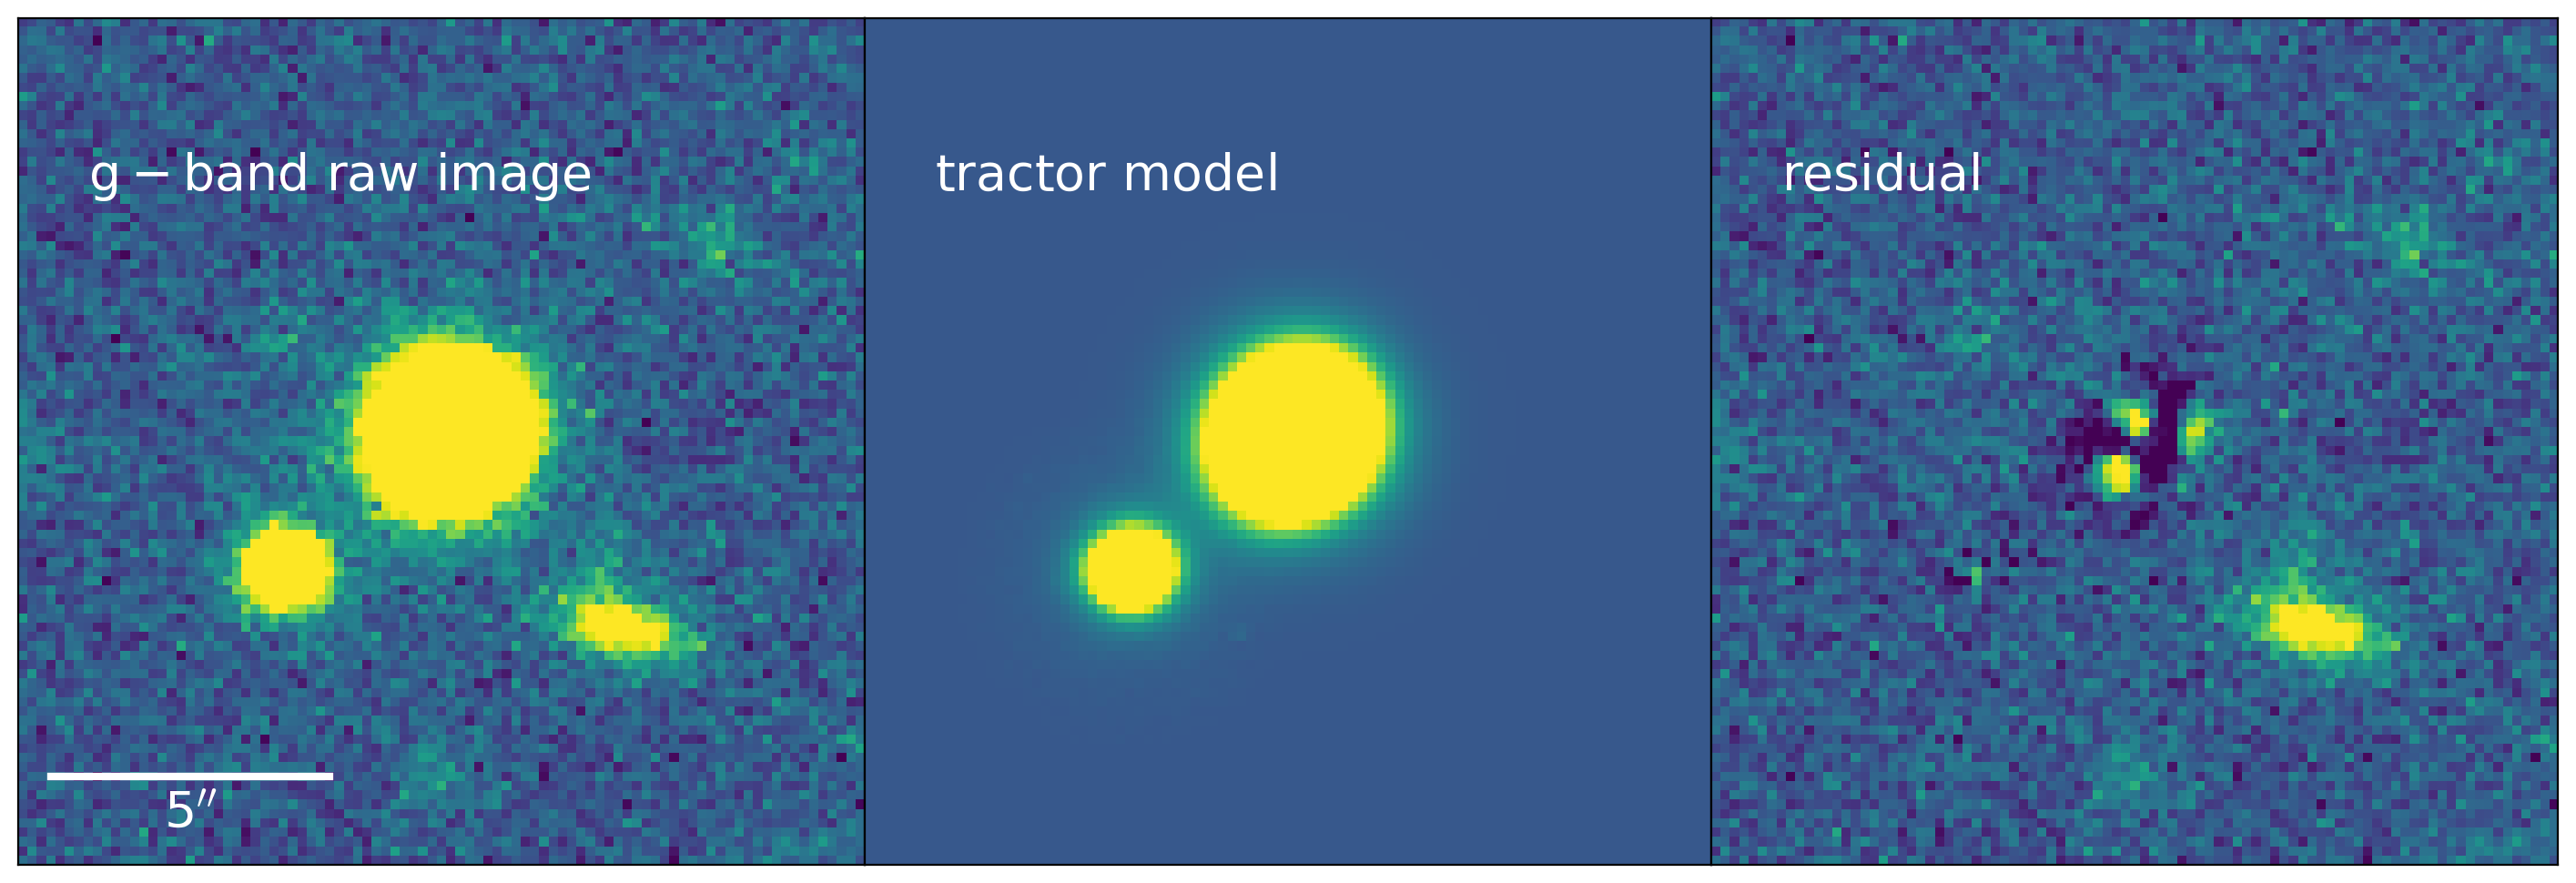

   The chi-square is 7.508434e-05
 - Now you have 3 sources


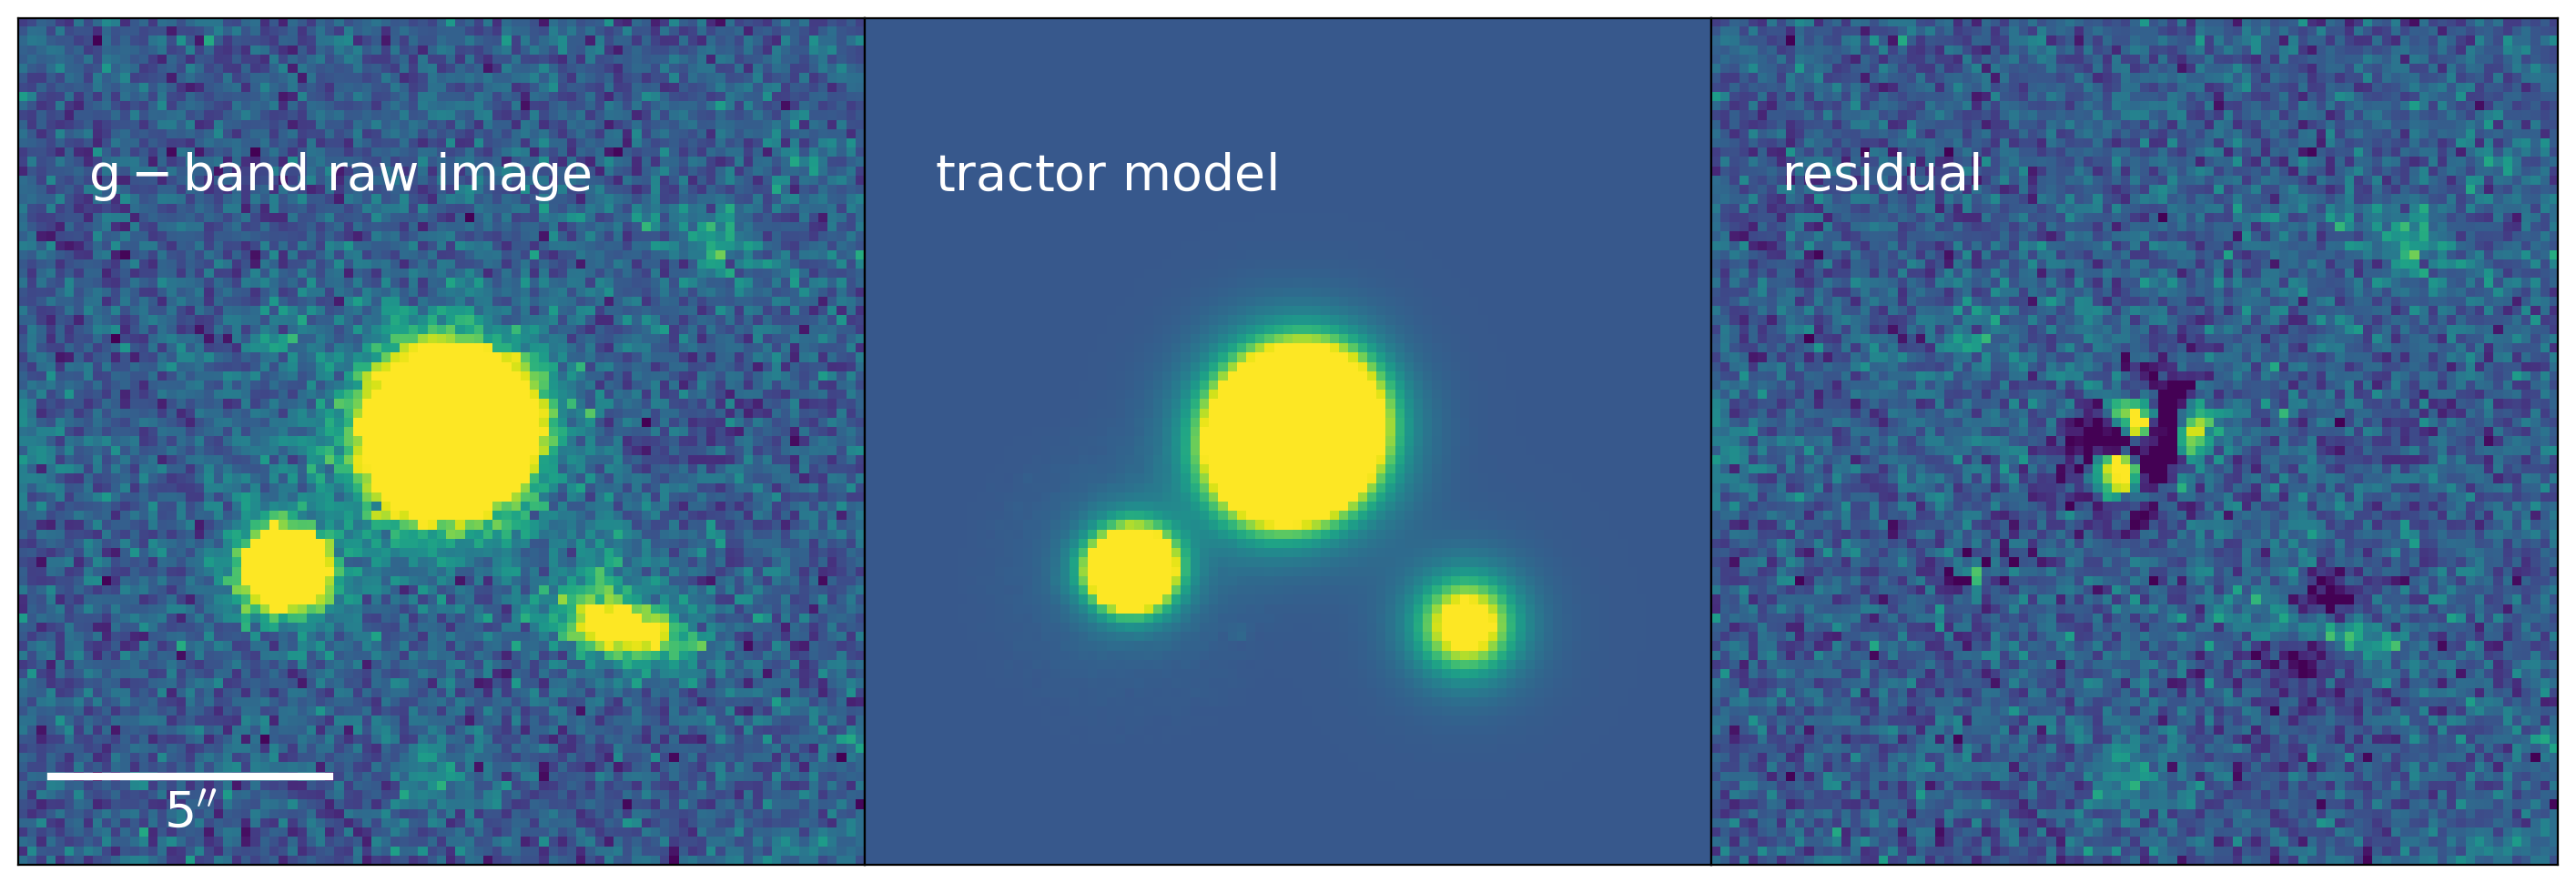

   The chi-square is 6.381924e-05
### `ladybug_180` r-band
    Detected 3 objects
!!!The file "./tractor-1498p025.fits" already exists!!!
# Type of the central object is REX
# Total number of objects: 3
 - Now you have 1 sources
 - Now you have 2 sources


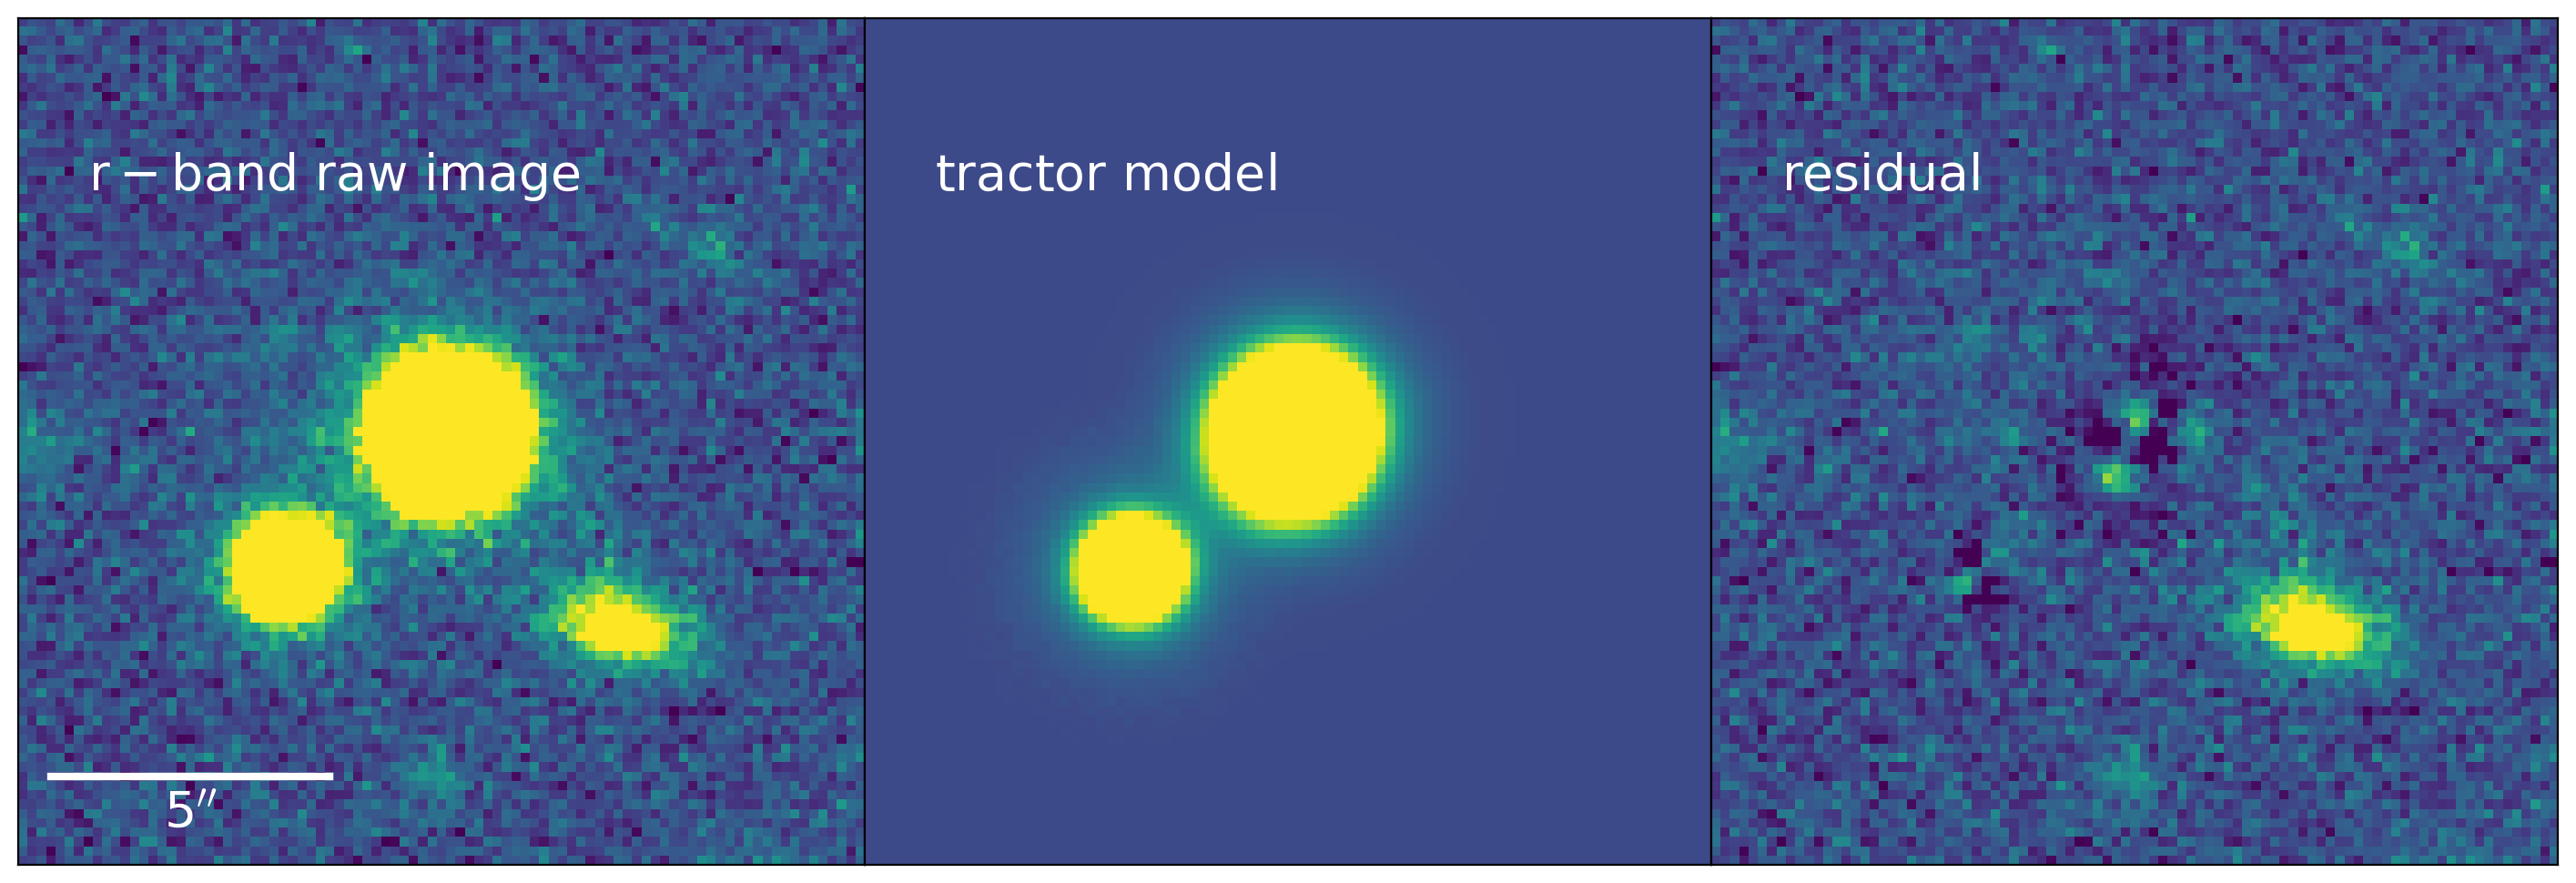

   The chi-square is 6.749485e-05
 - Now you have 3 sources


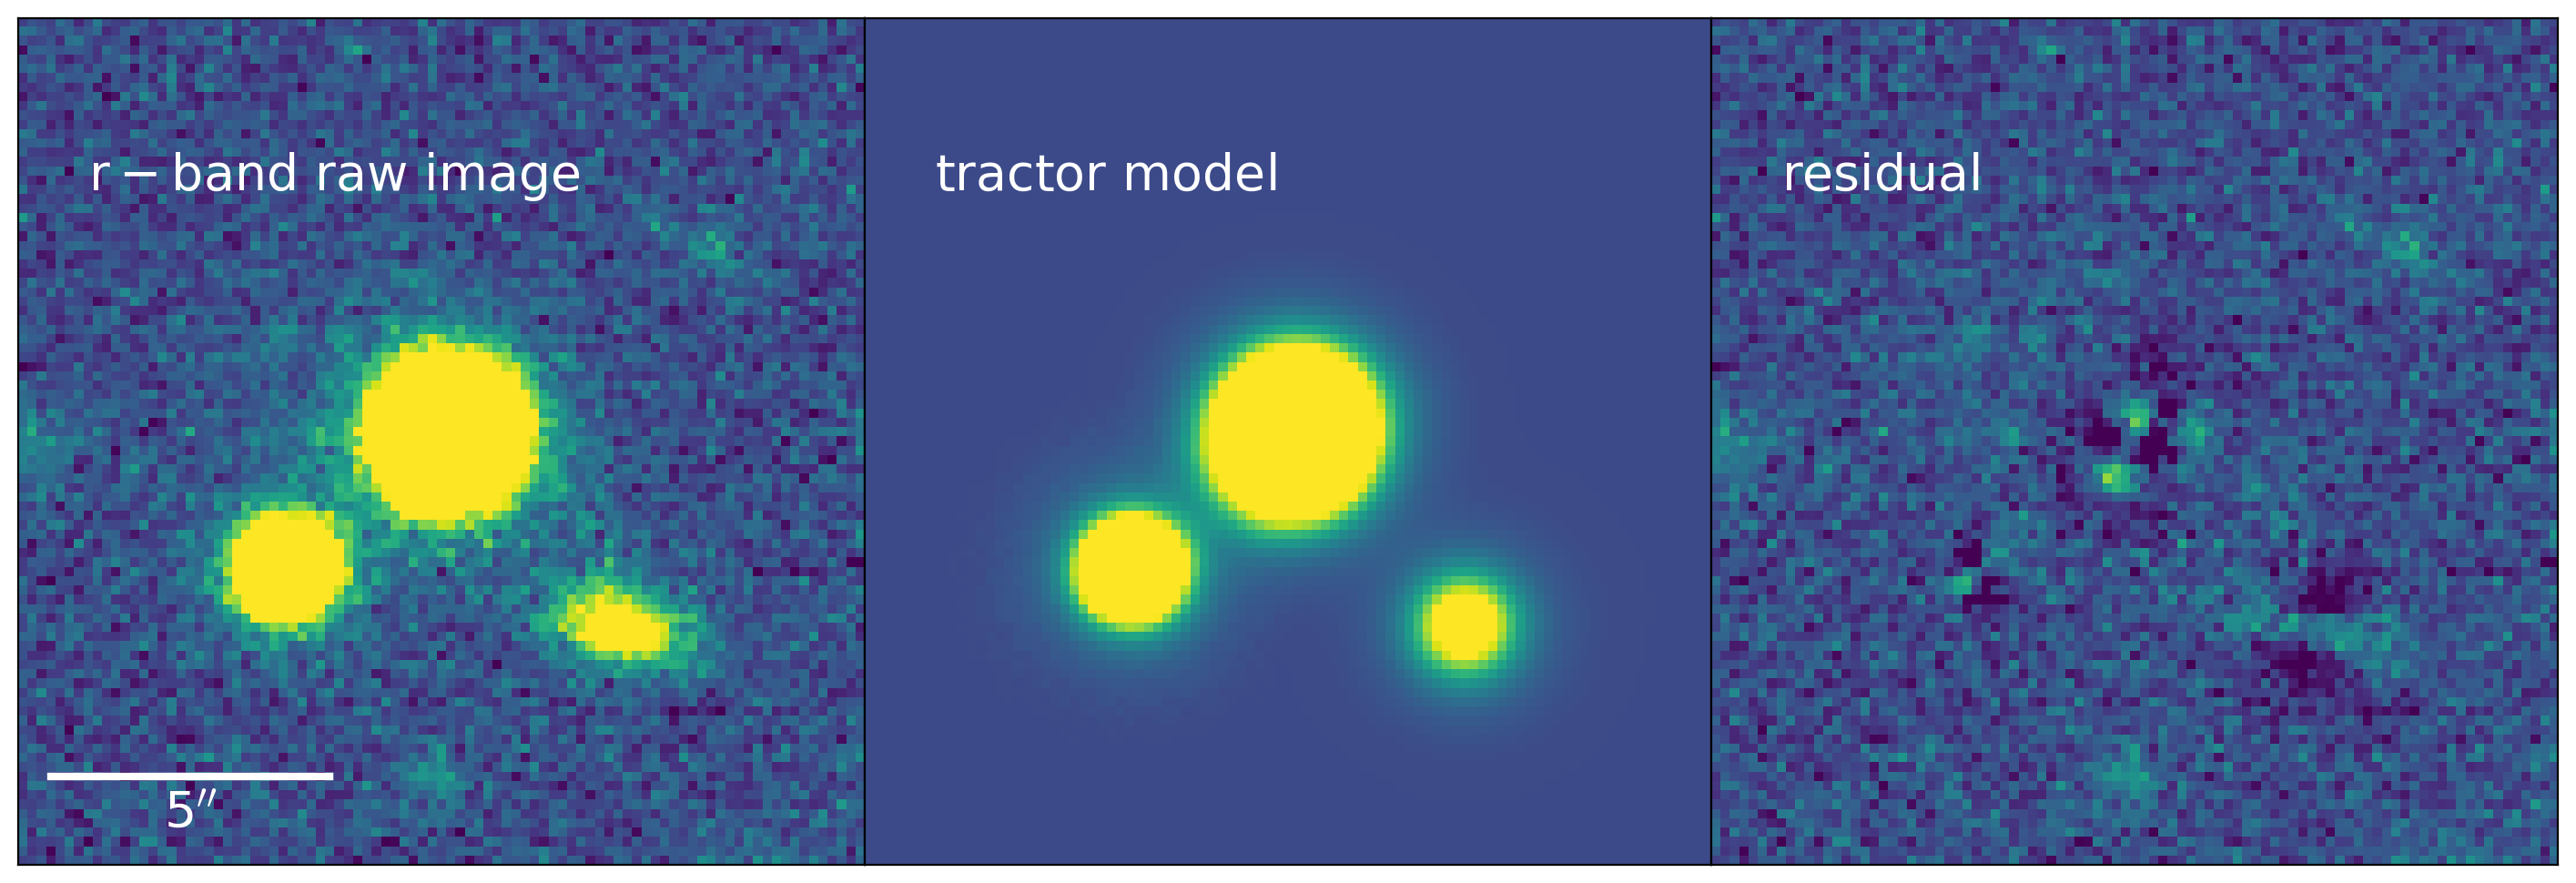

   The chi-square is 5.0273284e-05
### `ladybug_180` i-band
    Detected 4 objects
!!!The file "./tractor-1498p025.fits" already exists!!!
# Type of the central object is REX
# Total number of objects: 4
 - Now you have 2 sources
 - Now you have 3 sources


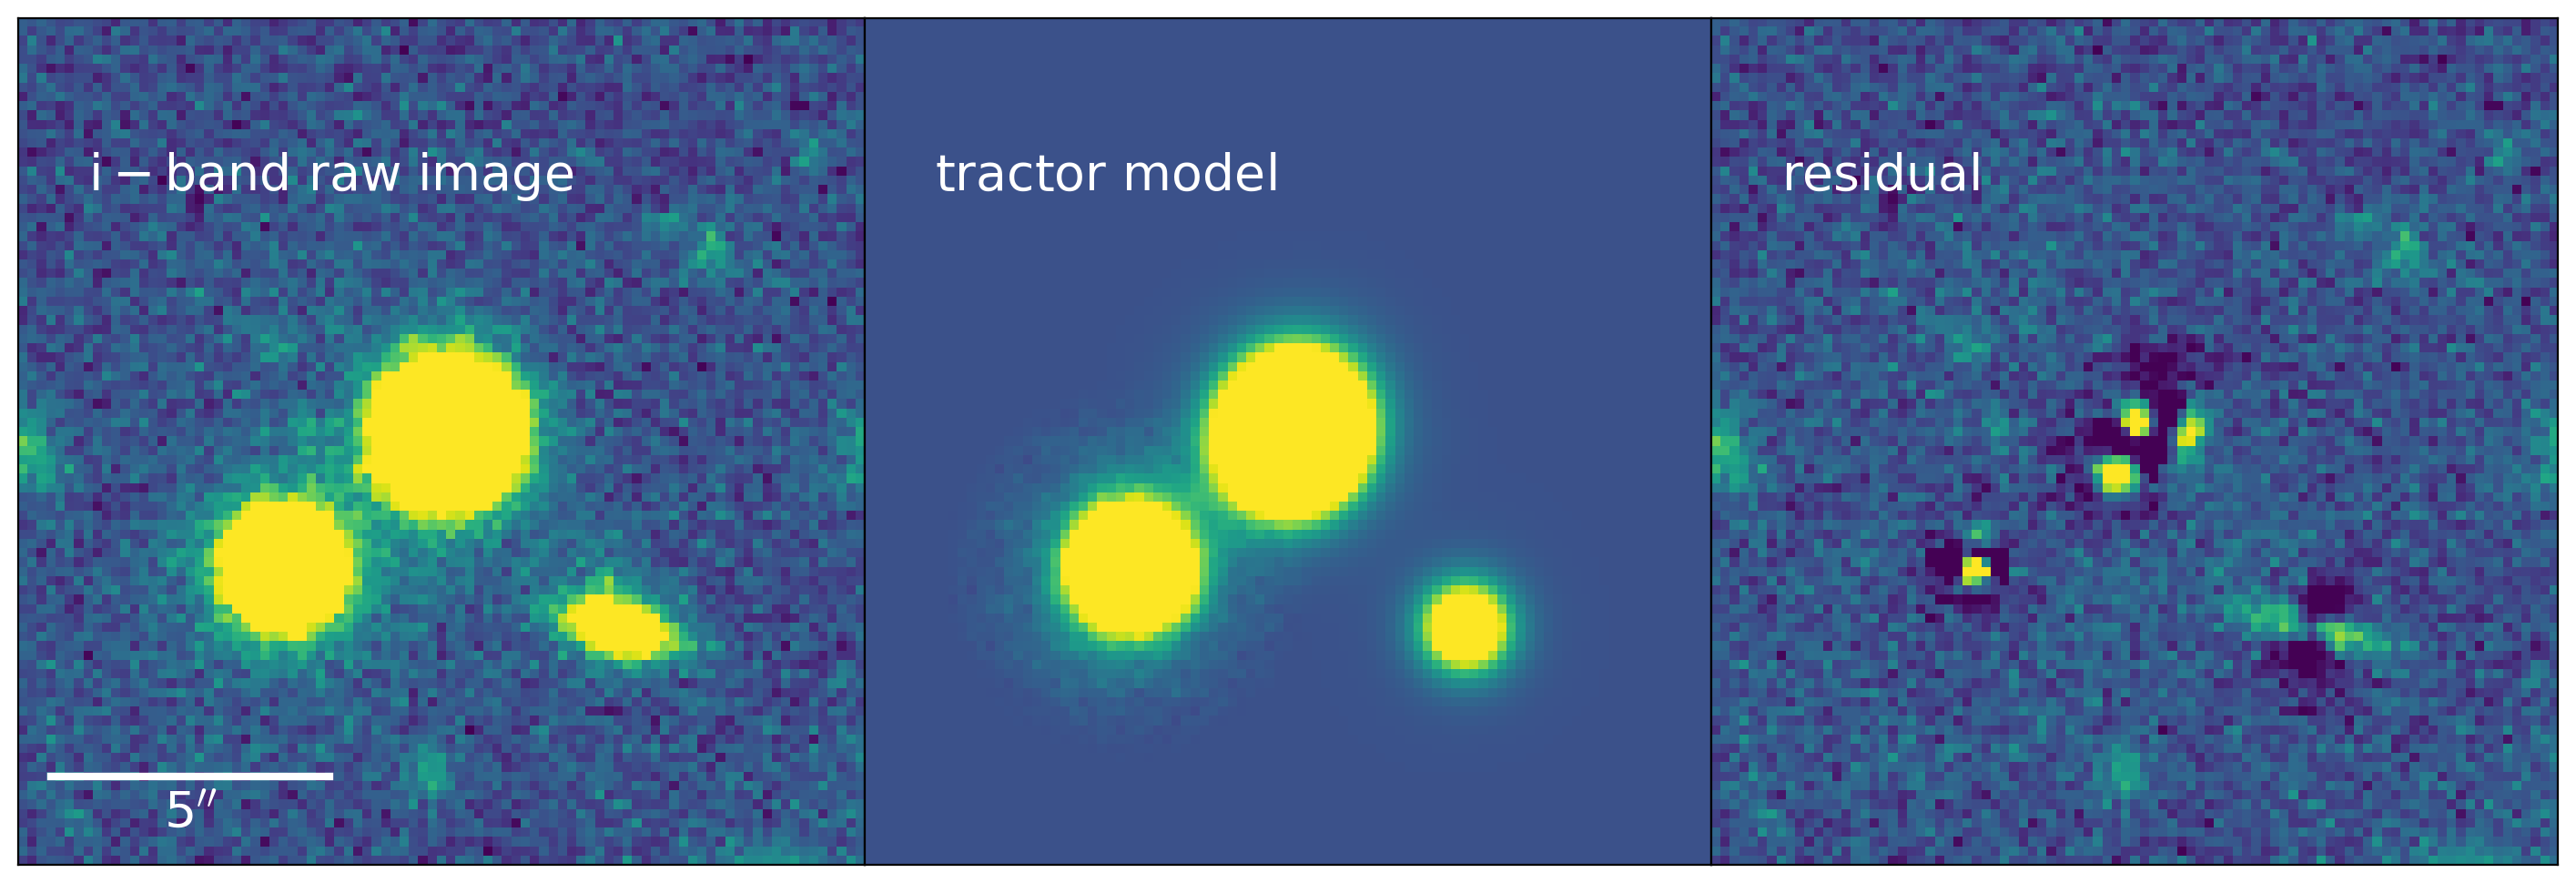

   The chi-square is 3.4893346e-05
 - Now you have 4 sources


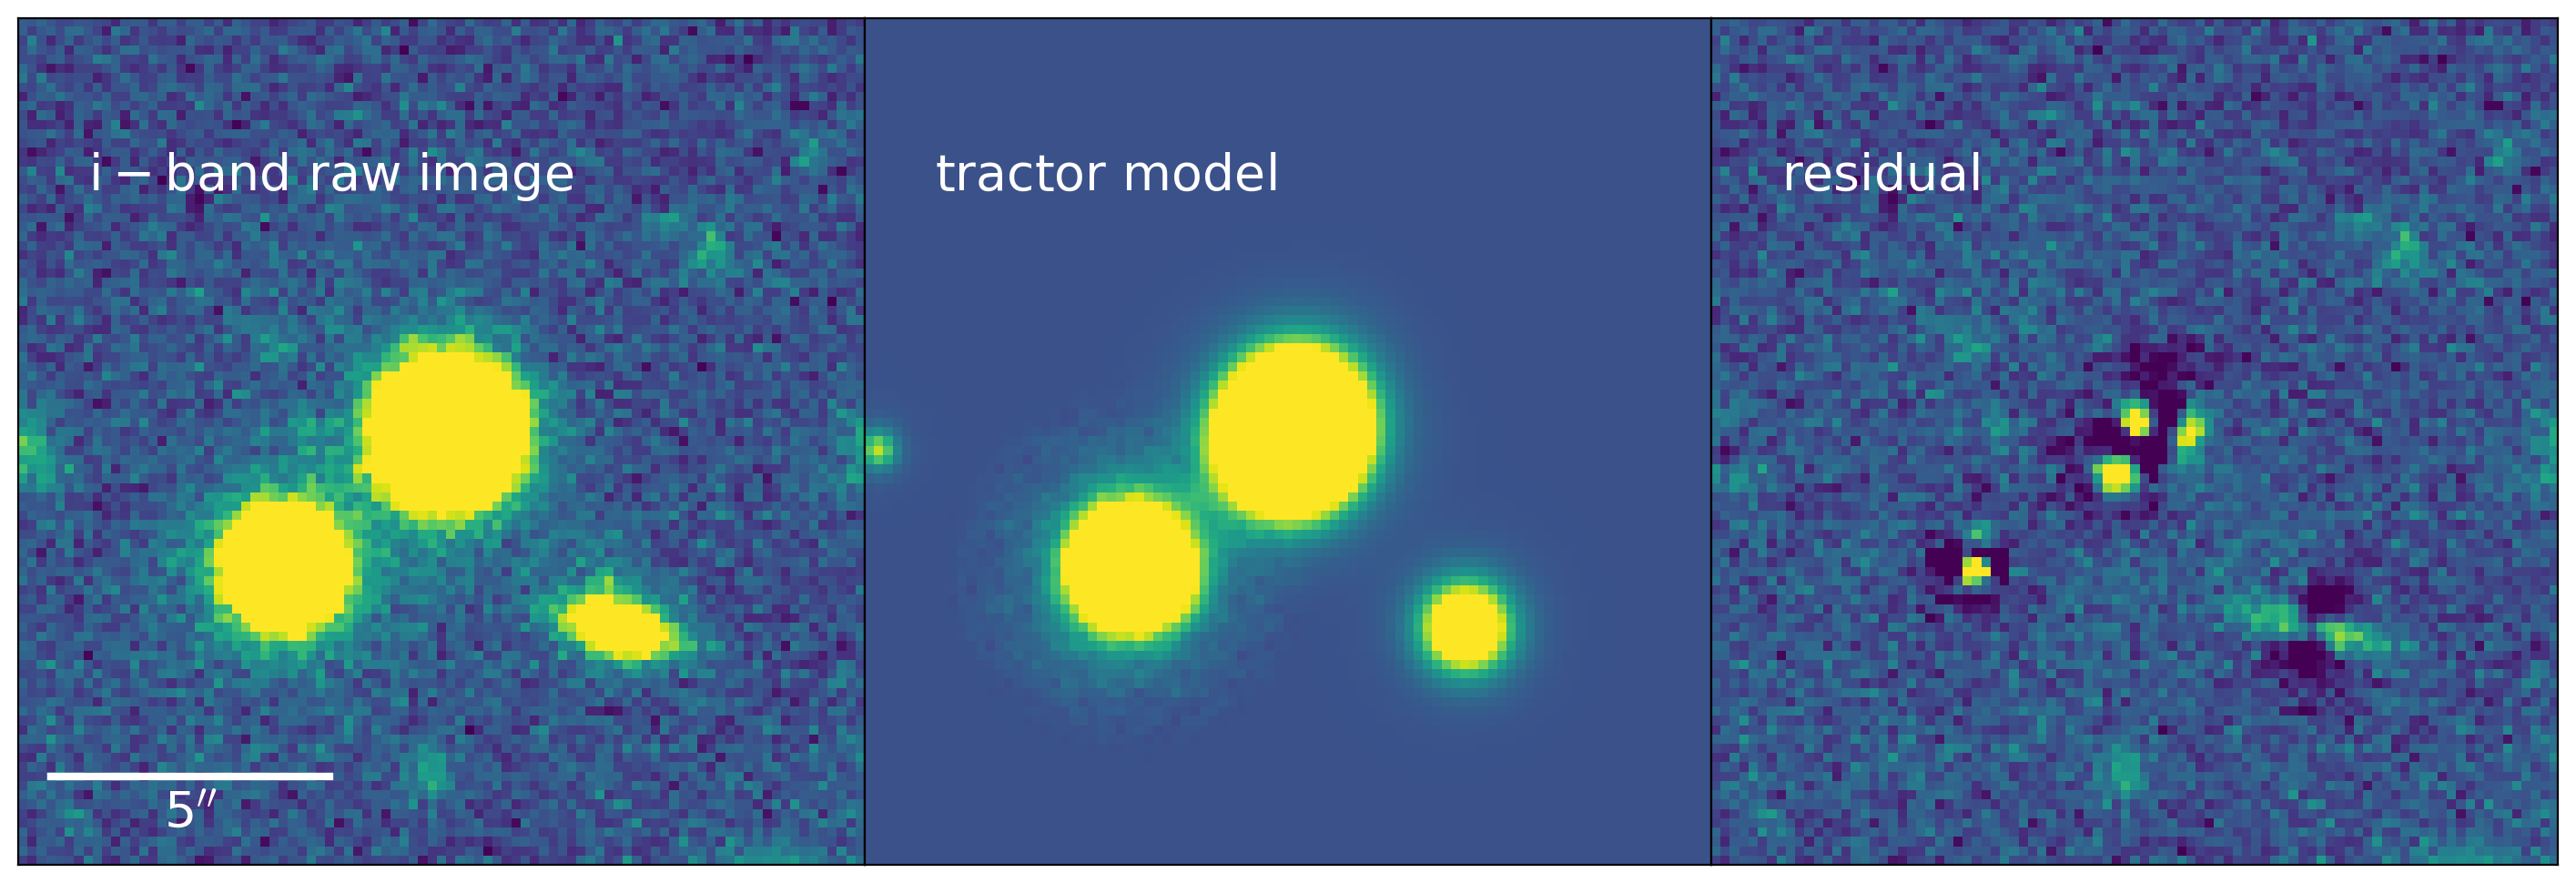

   The chi-square is 3.454967e-05
### `ladybug_180` z-band
    Detected 4 objects
!!!The file "./tractor-1498p025.fits" already exists!!!
# Type of the central object is REX
# Total number of objects: 4
 - Now you have 2 sources
 - Now you have 3 sources


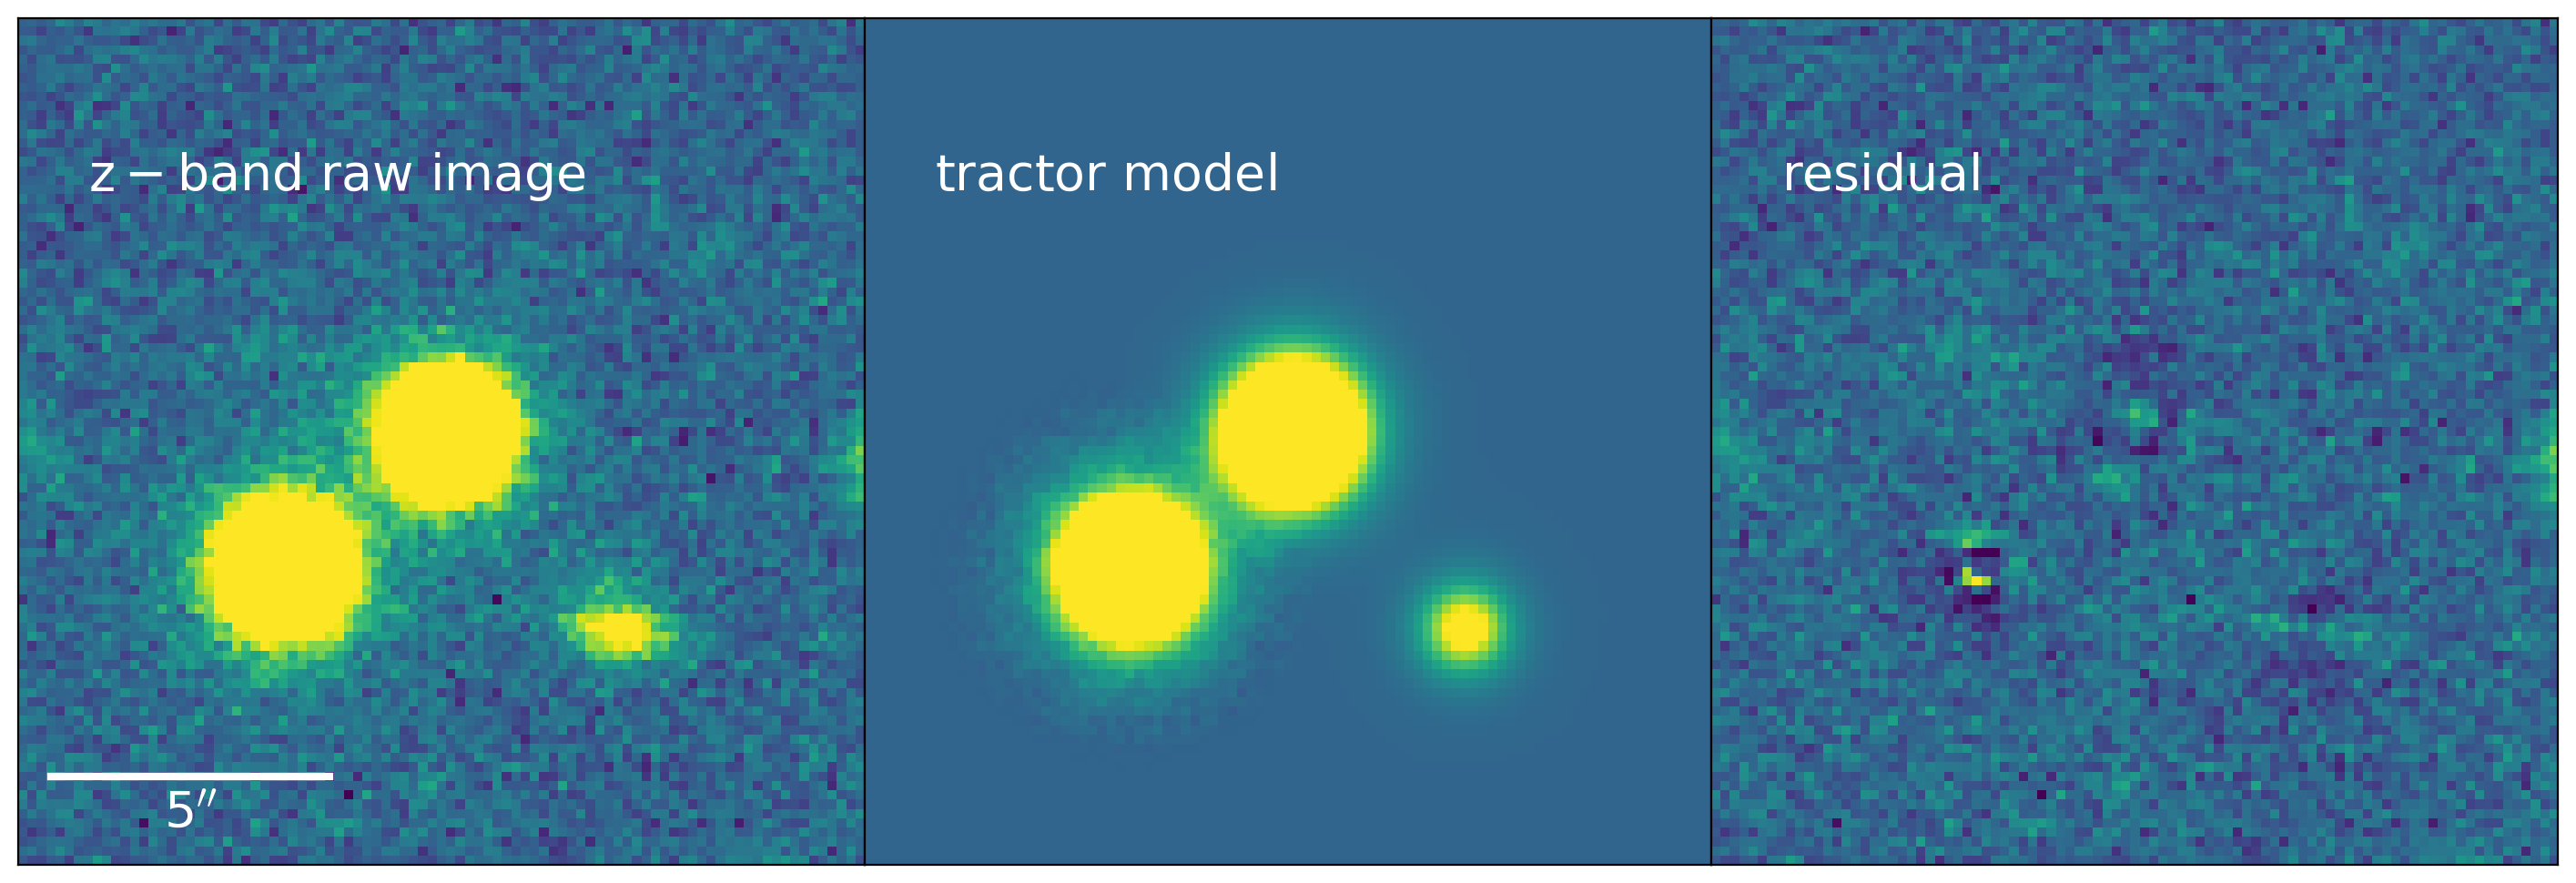

   The chi-square is 3.709772e-05
 - Now you have 4 sources


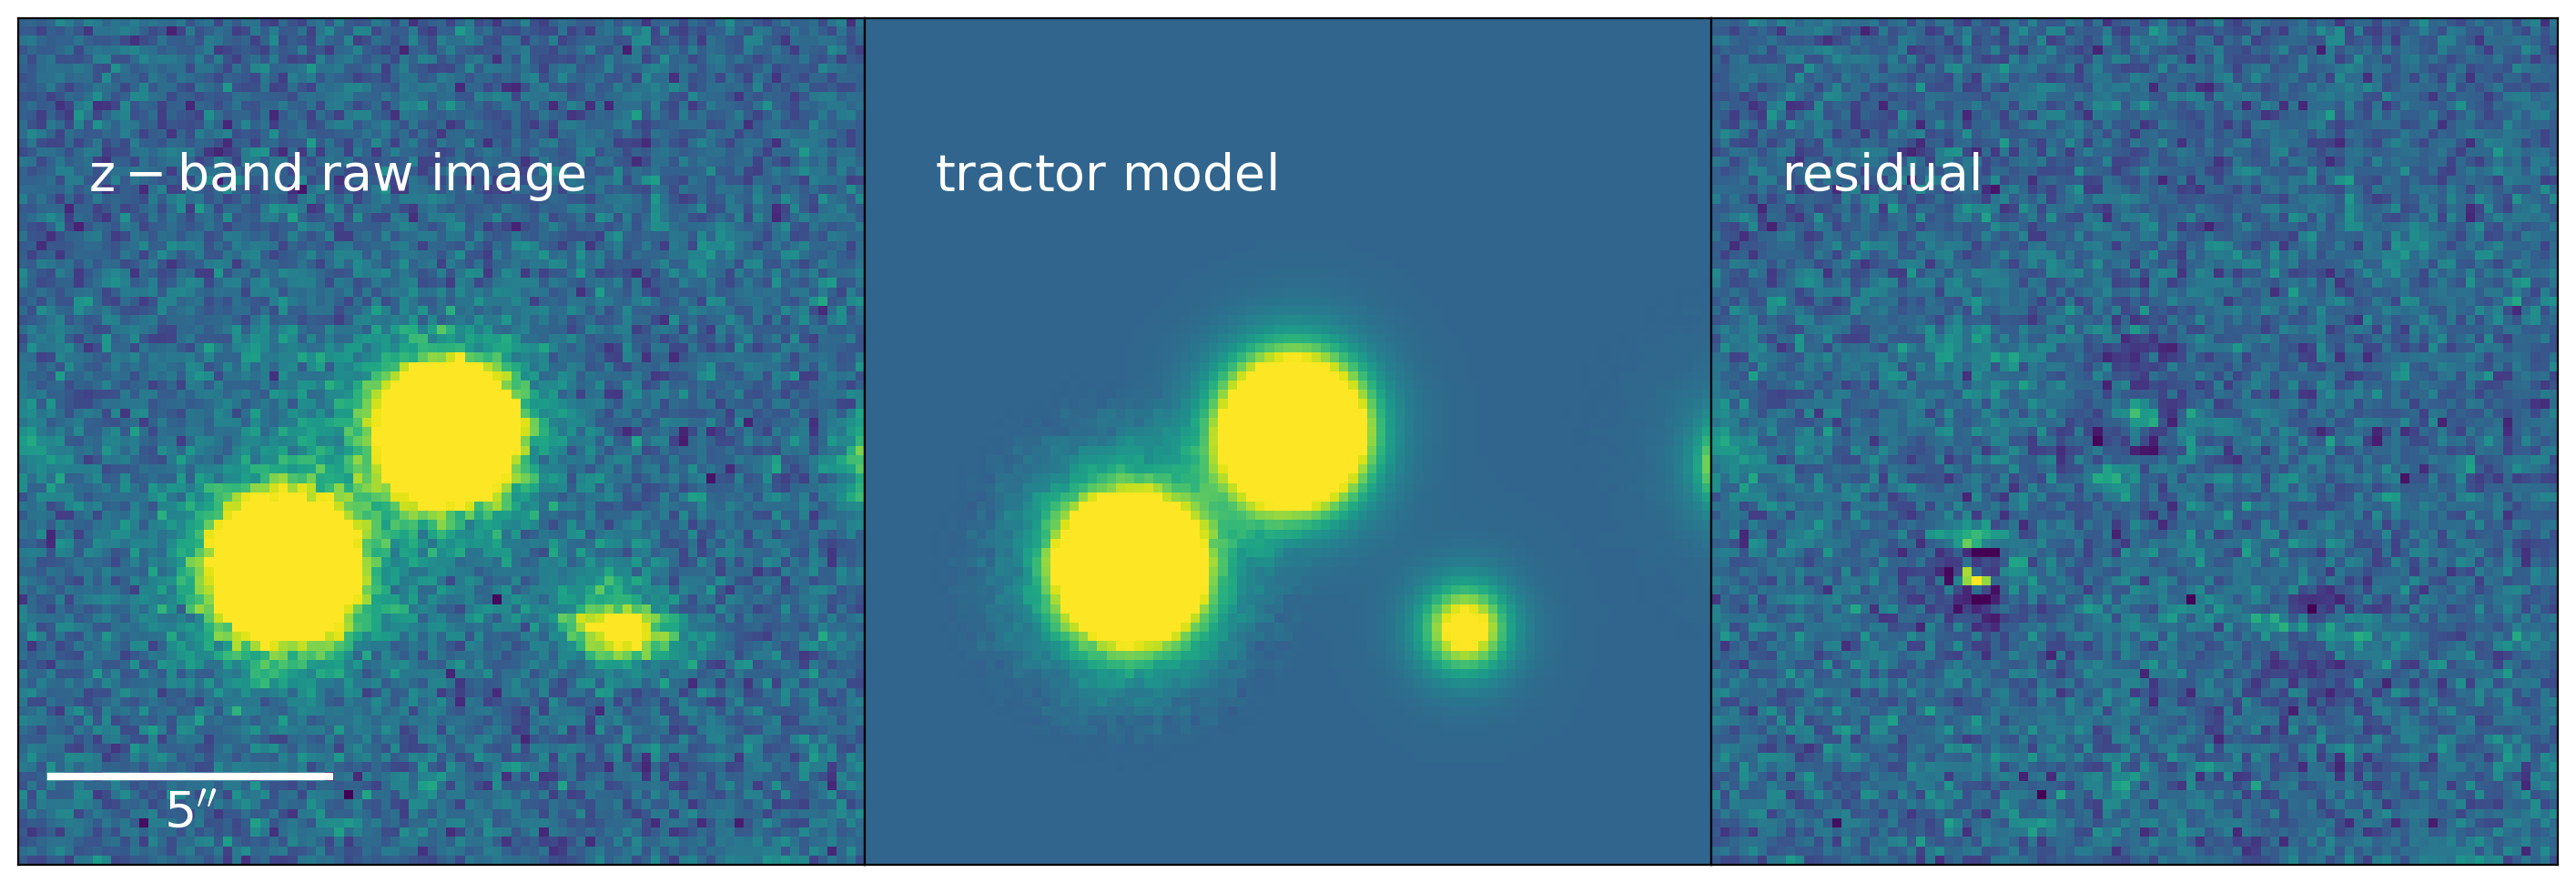

   The chi-square is 3.6523732e-05
### `ladybug_180` y-band
    Detected 3 objects
!!!The file "./tractor-1498p025.fits" already exists!!!
# Type of the central object is REX
# Total number of objects: 3
 - Now you have 2 sources
   index False out of range for table with length 0
 - Now you have 2 sources
 - Now you have 3 sources


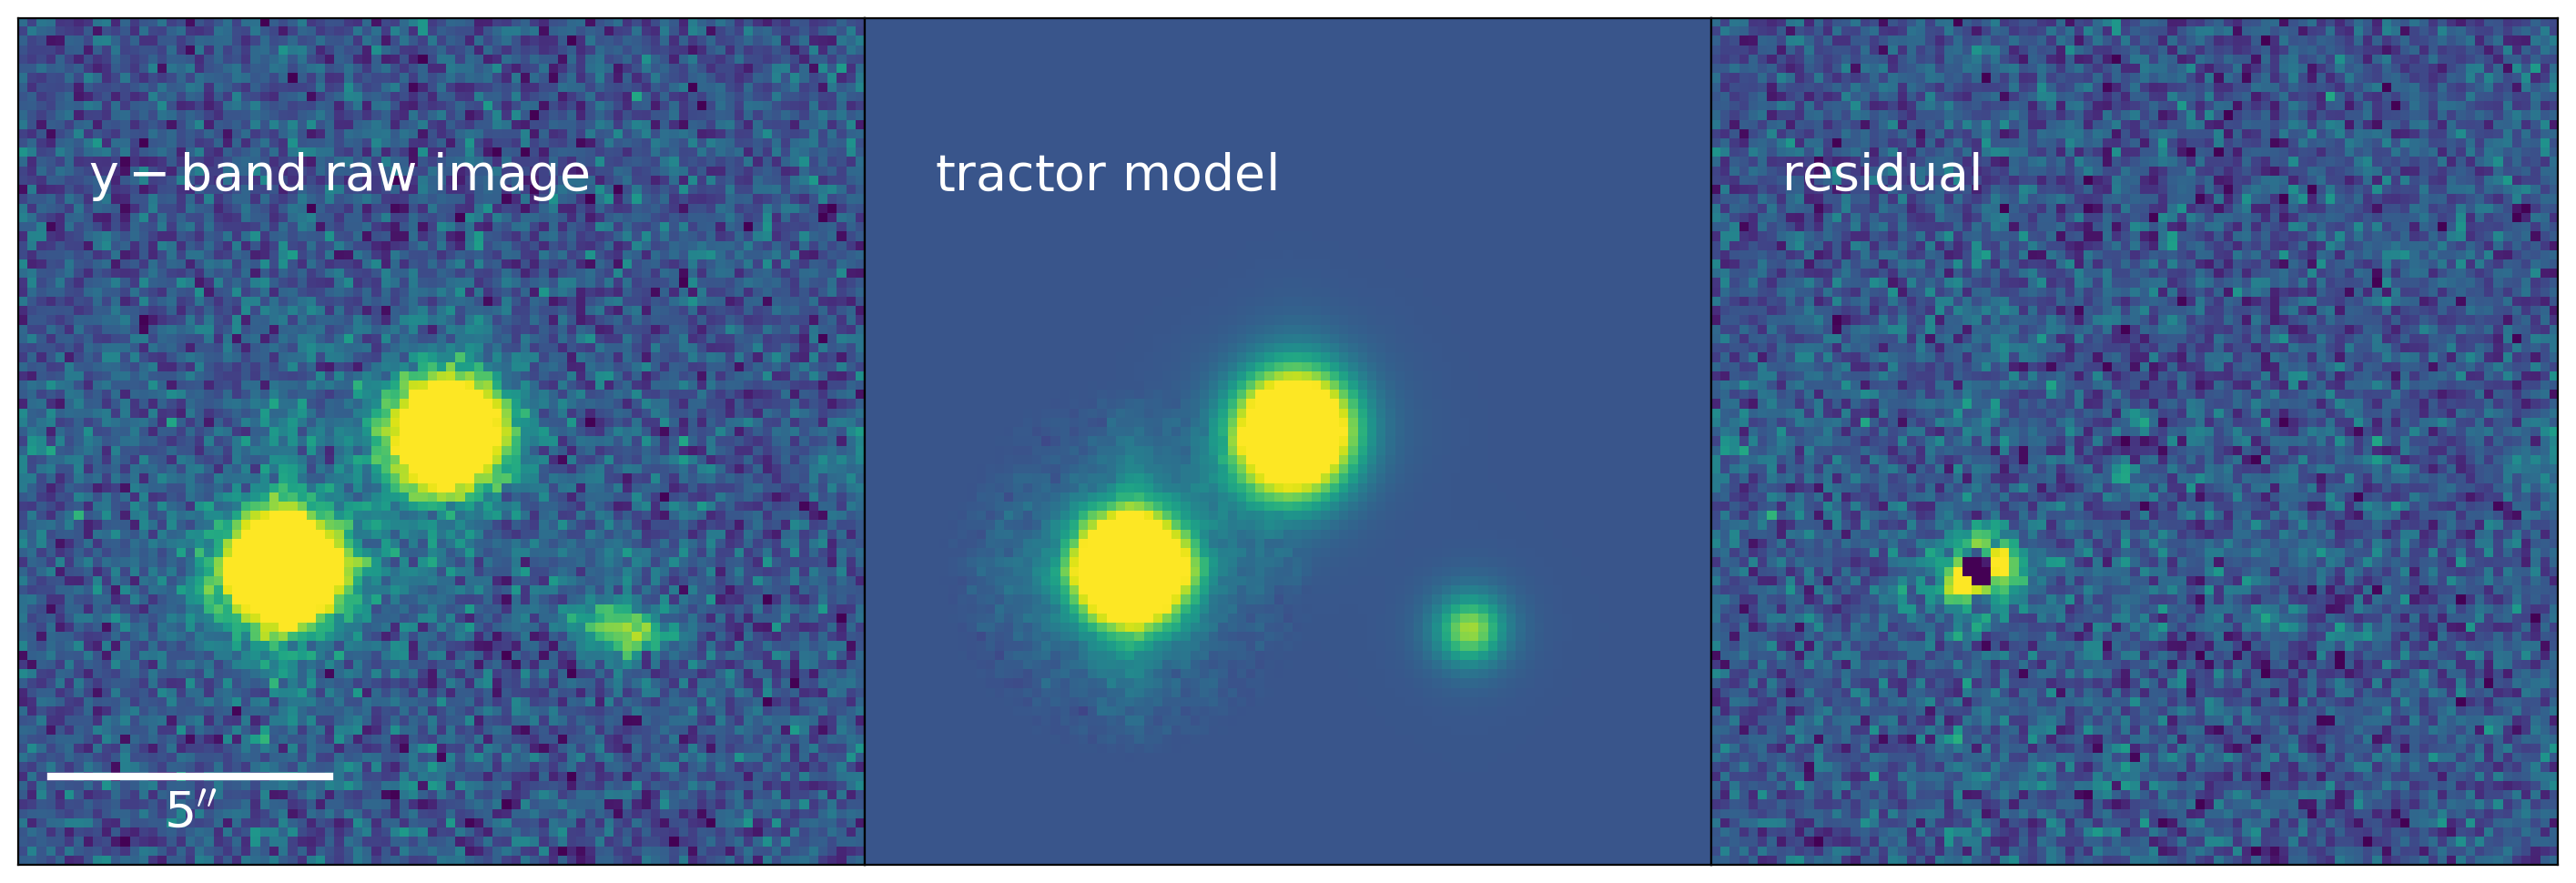

   The chi-square is 8.757311e-05


In [7]:
for obj in obj_cat[1:2]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('ladybug_')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/home/diana/Research/ladybug_tractor/ladybug/1/{obj_id}/hsc/ladybug_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    # Start fitting
    model_dict = {}
    for filt in channels:
        model_dict[filt] = tractor_hsc_sep(obj, filt, channels, data, 
                                           brick_file='/home/diana/Research/research_downloads/survey-bricks.fits.gz',
                                           freeze_pos=False, verbose=True)
    
    # tractor_hsc_sep (step by step): 
    # makeCatalog: creates a catalog from detected sources using SEP
    # catalog is then matched with DECaLS tractor catalogs, columns from 
    # DECaLs tractor catalog are appended to our own 
    # central obj is set as Sersic
    # then, move on to tractor which requires the psfs and priors (from HSC) 
    # there is an option to freeze parameters ie, source.freezeParam('pos')
    

    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
    

    #clear_output()
    #plt.close()